# ***START***

# Import Necessary Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import cv2
import random

#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DatasetForColab/EthnicLanguage/BdEthnicLanguages.csv')

In [ ]:
df.head()

,Converted Text,Language
0,𑄃𑄬𑄇𑄴 𑄎𑄧𑄚𑄴 𑄝𑄪𑄢𑄦 𑄟𑄚𑄪 𑄝𑄎𑄢𑄬 𑄃𑄇𑄴𑄑 𑄥𑄧𑄠𑄴𑄥𑄴𑄛𑄨𑄥𑄴 𑄘𑄪𑄘𑄪𑄇𑄮...,Chakma
1,𑄝𑄉𑄚𑄴 𑄇𑄮𑄢𑄨𑄠 𑄛𑄢𑄴𑄝𑄮𑄑𑄬𑄢𑄴 𑄣𑄉𑄮𑄑𑄴 𑄘𑄮𑄢𑄨 𑄘𑄮𑄢𑄨 𑄃𑄇𑄴𑄑 𑄌𑄨𑄑𑄨...,Chakma
2,𑄝𑄨𑄣𑄃𑄨 𑄚𑄮𑄘𑄨𑄢𑄴 𑄘𑄢𑄬 𑄃𑄇𑄴𑄑 𑄉𑄪𑄛𑄴𑄑𑄮 𑄇𑄮𑄑𑄦 𑄥𑄪𑄚𑄴𑄘𑄮𑄢 𑄝𑄝𑄬 ...,Chakma
3,𑄘𑄇𑄴𑄑𑄢𑄴 𑄝𑄎𑄢𑄬 𑄅𑄖𑄴𑄥𑄦𑄬 𑄃𑄇𑄴𑄑 𑄉𑄌𑄮𑄢𑄴 𑄝𑄦𑄨𑄣𑄮।,Chakma
4,𑄝𑄉𑄚𑄴 𑄇𑄮𑄢𑄨𑄠 𑄛𑄢𑄴𑄇𑄣𑄬 𑄘𑄮𑄢𑄨 𑄘𑄮𑄢𑄨 𑄃𑄇𑄴𑄑 𑄉𑄃𑄚𑄴 𑄃𑄁𑄇𑄨𑄣𑄮।,Chakma


In [ ]:
df.shape

(4713, 2)

In [ ]:
df['Language'].value_counts().reset_index()

,Language,count
0,Chakma,1057
1,Marma,966
2,Rakhine,906
3,Santali,869
4,Garo,822
5,Tripura,93


In [ ]:
df = df[df['Language'] != 'Tripura']

In [ ]:
df['Language'].value_counts().reset_index()

,Language,count
0,Chakma,1057
1,Marma,966
2,Rakhine,906
3,Santali,869
4,Garo,822


In [ ]:
max_count = df['Language'].value_counts().max()
max_count

1057

# Data Augmentation

In [ ]:
df.columns

Index(['Converted Text', 'Language'], dtype='object')

In [ ]:
def random_swap(words, n=1):
    words = words.copy()
    if len(words) < 2:
        return words
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return words

def random_deletion(words, p=0.2):
    if len(words) == 1:
        return words
    return [w for w in words if random.random() > p] or words  # fallback if all removed

def random_insertion(words, n=1):
    for _ in range(n):
        idx = random.randint(0, len(words)-1)
        words.insert(random.randint(0, len(words)), words[idx])
    return words

def augment_sentence(sentence):
    words = sentence.split()
    if len(words) < 2:
        return sentence

    method = random.choice(['swap', 'delete', 'insert'])
    if method == 'swap':
        aug_words = random_swap(words)
    elif method == 'delete':
        aug_words = random_deletion(words)
    elif method == 'insert':
        aug_words = random_insertion(words)
    else:
        aug_words = words

    return ' '.join(aug_words)

# Step 5: Perform augmentation + oversampling
augmented_data = []

for lang, group in df.groupby('Language'):
    original_texts = group['Converted Text'].tolist()  # updated column name
    needed = max_count - len(group)

    new_samples = []
    i = 0
    while len(new_samples) < needed:
        text = original_texts[i % len(original_texts)]
        aug_text = augment_sentence(text)
        new_samples.append({'Converted Text': aug_text, 'Language': lang})
        i += 1

    lang_df = pd.concat([group, pd.DataFrame(new_samples)], ignore_index=True)
    augmented_data.append(lang_df)

# Step 6: Combine and shuffle
balanced_df = pd.concat(augmented_data, ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 7: Save result
balanced_df.to_csv("balanced_tribal_augmented_dataset.csv", index=False)

print("✅ Dataset balanced and saved! Total samples:", len(balanced_df))
print(balanced_df['Language'].value_counts())

✅ Dataset balanced and saved! Total samples: 5285
Language
Marma       1057
Chakma      1057
Santali     1057
Garo        1057
Rakhine     1057
Name: count, dtype: int64


#Model Trianing

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Parameters
MAX_LEN = 300  # max number of characters per sample
CHAR_VOCAB = sorted(list(set(''.join(balanced_df['Converted Text']))))
char2idx = {c: i+1 for i, c in enumerate(CHAR_VOCAB)}  # reserve 0 for padding

# Encode text as character indices
def encode_text(text):
    return [char2idx.get(c, 0) for c in text[:MAX_LEN]]

X = balanced_df['Converted Text'].apply(encode_text).tolist()
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

# Encode labels
le = LabelEncoder()
y = le.fit_transform(balanced_df['Language'])
y = to_categorical(y)

print("✅ Text and labels encoded!")


✅ Text and labels encoded!


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

model = Sequential([
    Embedding(input_dim=210, output_dim=64, input_shape=(300,) ),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')  # assuming 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 300, 64)        │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 296, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,109 (246.52 KB)

 Trainable params: 63,109 (246.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.6386 - loss: 1.2306 - val_accuracy: 0.8780 - val_loss: 0.2582
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.8706 - loss: 0.2581 - val_accuracy: 0.9026 - val_loss: 0.2207
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.9152 - loss: 0.1960 - val_accuracy: 0.9196 - val_loss: 0.1760
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.9302 - loss: 0.1633 - val_accuracy: 0.9167 - val_loss: 0.1963
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9337 - loss: 0.1472 - val_accuracy: 0.9262 - val_loss: 0.1684
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.9536 - loss: 0.1197 - val_accuracy: 0.9290 - val_loss: 0.1450
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9584 - loss: 0.1021 - val_accuracy: 0.9300 - val_loss: 0.1454
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9676 - loss: 0.0904 - val_accura

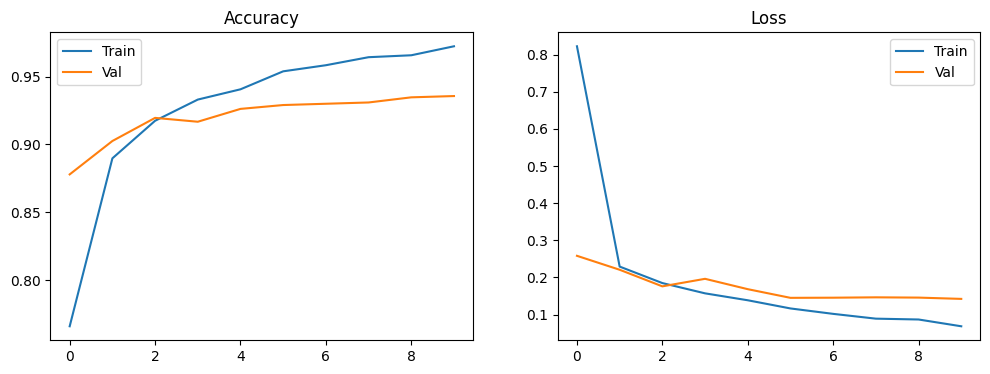

In [ ]:
import matplotlib.pyplot as plt

# Accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()


In [ ]:
print("Max token index:", X_train.max())


Max token index: 202


In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, batch_size=64)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9327 - loss: 0.1526
Validation Loss: 0.1422
Validation Accuracy: 0.9357
